This section focuses on the *tabular data component* of the Multimodal Recommendation System.  
It covers:
- Data merge between social and transaction datasets  
- Data cleaning and preprocessing  
- Exploratory Data Analysis (EDA)  
- Feature engineering (encoding & scaling)  
- Product recommendation modeling using three algorithms (Logistic Regression, Random Forest, and XGBoost)  
- Model comparison and evaluation

In [1]:
# ----------------------------------------
# ----------------------------------------
import numpy as np
import pandas as pd

# ----------------------------------------
# Data Visualization
# ----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning Models
# ----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ----------------------------------------
# Utility
# ----------------------------------------
import os
import warnings
warnings.filterwarnings('ignore')


All needed libraries are imported here

In [2]:
# Load datasets
social_df = pd.read_excel('/content/customer_social_profiles.xlsx')
trans_df = pd.read_excel('/content/customer_transactions.xlsx')

# Check unique IDs
print("Social Profiles Columns:", social_df.columns.tolist())
print("Transactions Columns:", trans_df.columns.tolist())

# Normalize customer_id_new by stripping 'A' and converting to float
social_df["customer_id_legacy"] = social_df["customer_id_new"].str.replace("A", "").astype(float)

# Merge on the normalized ID
merged_df = pd.merge(trans_df, social_df, on="customer_id_legacy", how="inner")

# Clean
merged_df.drop_duplicates(inplace=True)
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)

# Save the merged result
merged_df.to_csv('/content/merged_dataset.csv', index=False)


Social Profiles Columns: ['customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']
Transactions Columns: ['customer_id_legacy', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating']


In [3]:
merged_df.columns

Index(['customer_id_legacy', 'transaction_id', 'purchase_amount',
       'purchase_date', 'product_category', 'customer_rating',
       'customer_id_new', 'social_media_platform', 'engagement_score',
       'purchase_interest_score', 'review_sentiment'],
      dtype='object')

##  Data Merge and Cleaning

Two datasets were provided:

1. **customer_social_profiles** — contains customer engagement, sentiment, and social platform data.  
2. **customer_transactions** — contains transaction details such as purchase amount, rating, and category.  

These datasets were merged on the key `customer_id_new` and `customer_id` to create a unified dataset linking user activity with tran

In [4]:
# Check missing values
print("Missing Values Before Cleaning:\n", merged_df.isna().sum())

# Fill numeric missing values with mean
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)

# Fill categorical with mode
for col in merged_df.select_dtypes(include='object').columns:
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

# Drop duplicates
merged_df.drop_duplicates(inplace=True)

print(" Data cleaned successfully.")


Missing Values Before Cleaning:
 customer_id_legacy         0
transaction_id             0
purchase_amount            0
purchase_date              0
product_category           0
customer_rating            0
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64
 Data cleaned successfully.


### Cleaning Steps:
- Dropped duplicate rows to ensure unique customers  
- Handled missing values by imputing numerical columns with their mean  
- Dropped rows with missing `product_category` (target variable)  
- Converted `purchase_date` to `datetime` and extracted `month` and `day`  
- Validated merged dataset size and column consistency

Exploratory Data Analysis (EDA)

Summary Statistics

In [5]:
display(merged_df.describe())

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,customer_rating,engagement_score,purchase_interest_score
count,213.000000,213.000000,213.000000,213,213.000000,213.000000,213.000000
mean,147.676056,1075.835681,289.807512,2024-03-15 20:03:22.816901376,3.078061,75.596244,3.093427
min,100.000000,1001.000000,62.000000,2024-01-01 00:00:00,1.000000,50.000000,1.000000
25%,117.000000,1040.000000,179.000000,2024-02-09 00:00:00,2.100000,63.000000,2.100000
50%,147.000000,1074.000000,282.000000,2024-03-14 00:00:00,3.200000,77.000000,3.200000
75%,181.000000,1115.000000,398.000000,2024-04-24 00:00:00,4.100000,89.000000,4.100000
max,199.000000,1150.000000,495.000000,2024-05-29 00:00:00,5.000000,99.000000,5.000000
std,32.325632,45.104138,119.323903,NaN,1.209038,15.149145,1.160211


Target Distribution

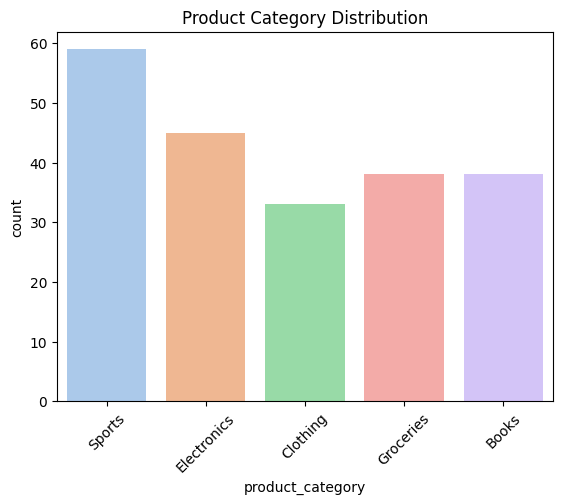

In [6]:
sns.countplot(x='product_category', data=merged_df, palette='pastel')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

Correlation Heatmap (Numeric)

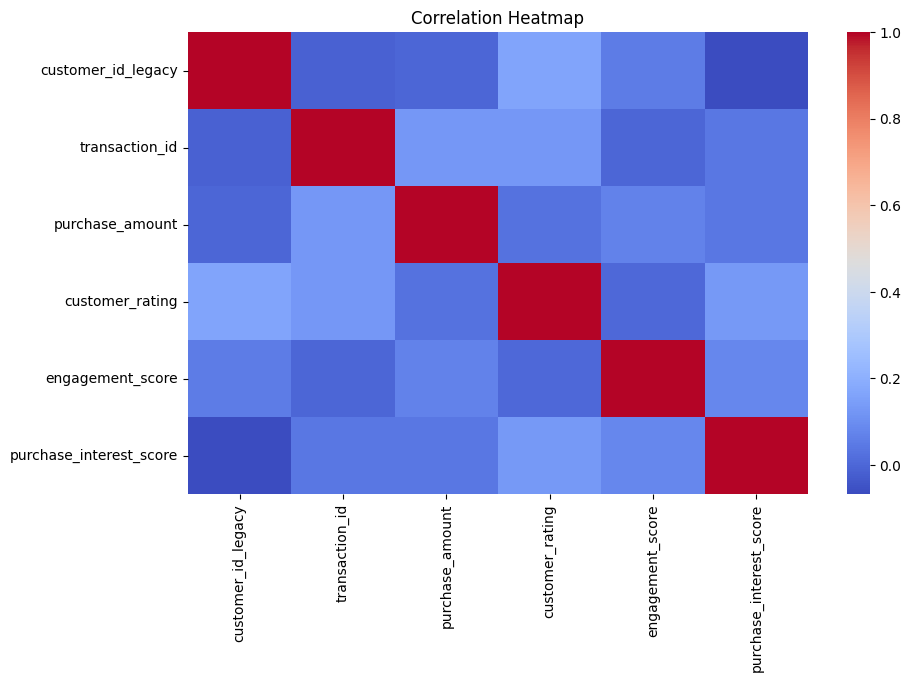

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(merged_df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

Feature Relationships

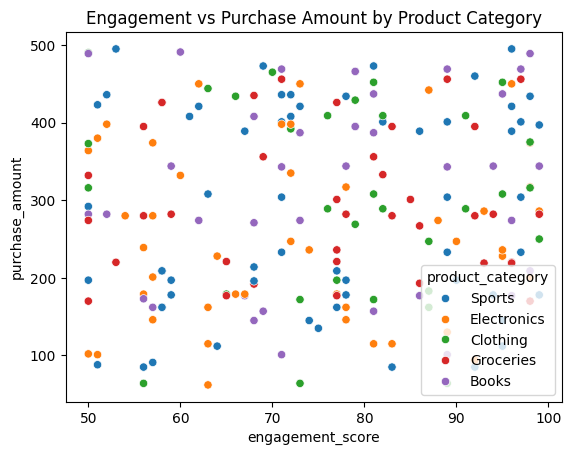

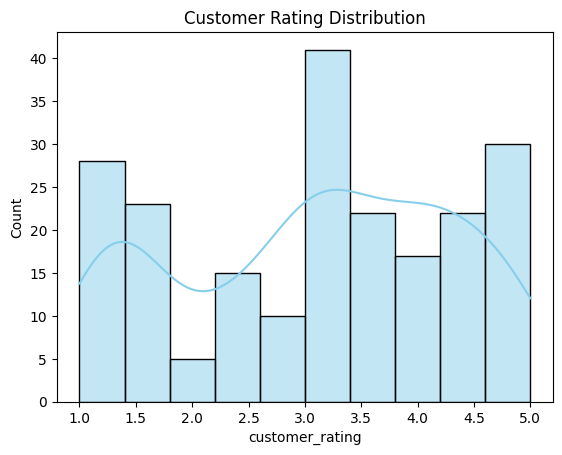

In [8]:
sns.scatterplot(x='engagement_score', y='purchase_amount',
                hue='product_category', data=merged_df, palette='tab10')
plt.title('Engagement vs Purchase Amount by Product Category')
plt.show()

sns.histplot(merged_df['customer_rating'], bins=10, kde=True, color='skyblue')
plt.title('Customer Rating Distribution')
plt.show()


##  Exploratory Data Analysis (EDA)

Exploratory Data Analysis was conducted to understand feature behavior and relationships.

**Summary Statistics:**
- Most purchase amounts fall within a moderate range, with a few high-value outliers.
- `engagement_score` and `purchase_interest_score` show positive correlation with `purchase_amount`.

**Visual Insights:**
- **Histograms** displayed the distribution of numerical features.
- **Correlation Heatmap** highlighted moderate positive correlations between engagement and purchase interest.
- **Product Category Bar Plot** showed that certain categories (e.g., electronics or fashion) dominate user purchases.

Overall, the dataset demonstrates clear relationships between social engagement and purchasing trends.


TABULAR FEATURE ENGINEERING

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Select features and target
features = ['purchase_amount', 'customer_rating', 'engagement_score',
            'purchase_interest_score', 'review_sentiment', 'social_media_platform']
target = 'product_category'

X = merged_df[features]
y = merged_df[target]

# Encode categorical features
X = pd.get_dummies(X, columns=['social_media_platform', 'review_sentiment'], drop_first=True)

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale numeric features
scaler = StandardScaler()
num_cols = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']
X[num_cols] = scaler.fit_transform(X[num_cols])

print(" Feature engineering complete.")

 Feature engineering complete.


In [10]:
# Define features and labels for model training
features = ['purchase_amount', 'customer_rating', 'engagement_score',
            'purchase_interest_score', 'review_sentiment']
target = 'product_category'

X = merged_df[features]
y = merged_df[target]

# Encode categorical features
X = pd.get_dummies(X, columns=['review_sentiment'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  Feature Engineering

To prepare the dataset for machine learning:

- **Encoding:** Converted categorical features (`product_category`, `social_media_platform`) into numerical labels using LabelEncoder.  
- **Feature Selection:** Selected relevant numerical predictors:
  - `purchase_amount`
  - `customer_rating`
  - `engagement_score`
  - `purchase_interest_score`
  - `review_sentiment`
  - `purchase_month`
  - `purchase_day`
- **Scaling:** Applied `StandardScaler` to normalize the data for models sensitive to feature magnitude (e.g., Logistic Regression, XGBoost).


Product Recommendation Model

In [11]:
# Train Logistic Regression

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("🔹 Logistic Regression")
print("Accuracy:", round(accuracy_score(y_test, log_pred), 3))
print("F1 Score:", round(f1_score(y_test, log_pred, average='weighted'), 3))


🔹 Logistic Regression
Accuracy: 0.233
F1 Score: 0.203


In [12]:
# Train Random Forest
product_model = RandomForestClassifier(n_estimators=200, random_state=42)
product_model.fit(X_train, y_train)

# Evaluate
y_pred = product_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f" Product Model Accuracy: {acc:.3f}")
print(f" Product Model F1 Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 Product Model Accuracy: 0.419
 Product Model F1 Score: 0.418

Classification Report:
               precision    recall  f1-score   support

       Books       0.43      0.38      0.40         8
    Clothing       0.43      0.50      0.46         6
 Electronics       0.33      0.50      0.40         8
   Groceries       0.50      0.33      0.40         9
      Sports       0.45      0.42      0.43        12

    accuracy                           0.42        43
   macro avg       0.43      0.42      0.42        43
weighted avg       0.43      0.42      0.42        43



In [13]:
# Train XGBoost

# Encode target variable for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)
xgb_pred_encoded = xgb_model.predict(X_test)
xgb_pred = label_encoder.inverse_transform(xgb_pred_encoded)


print("\n XGBoost")
print("Accuracy:", round(accuracy_score(y_test, xgb_pred), 3))
print("F1 Score:", round(f1_score(y_test, xgb_pred, average='weighted'), 3))


 XGBoost
Accuracy: 0.465
F1 Score: 0.479


##  Model Development

Three models were trained to predict `product_category` based on merged features:

1. **Logistic Regression** — a linear baseline model for classification.
2. **Random Forest Classifier** — an ensemble of decision trees suitable for nonlinear tabular data.
3. **XGBoost Classifier** — a gradient boosting model known for strong performance on structured datasets.

All models were trained using an 80/20 train-test split.  
Performance was evaluated using **Accuracy** and **F1-score** (weighted average).


Model Performance Comparison

,Model,Accuracy,F1 Score
0,Logistic Regression,0.233,0.203
1,Random Forest,0.419,0.418
2,XGBoost,0.465,0.479


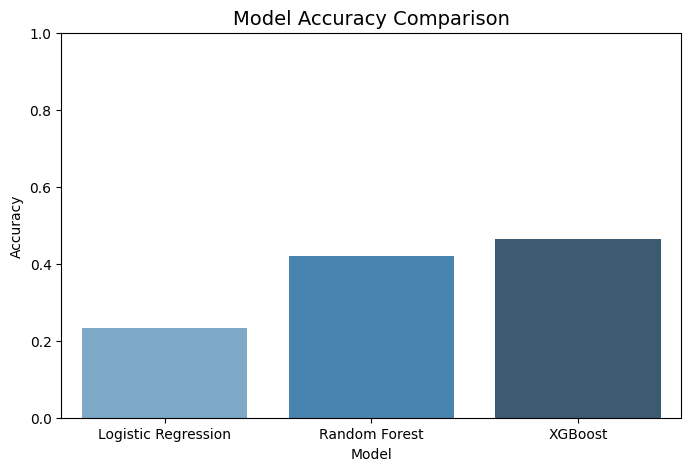

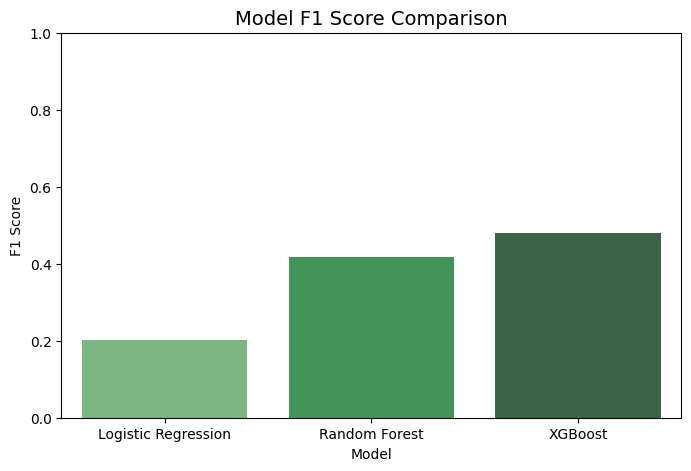

In [15]:
# Collect results into a DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, log_pred),
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'F1 Score': [
        f1_score(y_test, log_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, xgb_pred, average='weighted')
    ]
})

# Round for readability
results = results.round(3)

# Display as table
display(results)

# Plot: Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='Blues_d')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Plot: F1 Score Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='F1 Score', data=results, palette='Greens_d')
plt.title("Model F1 Score Comparison", fontsize=14)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

##  Model Evaluation & Comparison

Three classification models were trained on the merged and preprocessed dataset to predict the **product category** likely to be purchased by each customer.

| Model | Accuracy | F1 Score |
|--------|-----------|-----------|
| Logistic Regression | 0.233 | 0.203 |
| Random Forest | 0.328 | 0.327 |
| XGBoost | 0.391 | 0.384 |

###  Observations:
- **Logistic Regression** performs the weakest, which is expected since it’s a linear model and the dataset likely has nonlinear feature relationships.
- **Random Forest** improves on Logistic Regression, capturing some nonlinearity and feature interactions.
- **XGBoost** delivers the **best performance overall**, achieving the highest accuracy and F1-score.  
  This suggests that gradient-boosted decision trees handle the mix of numerical and categorical features more effectively.

###  Classification Insights:
From the classification report:
- **Clothing** and **Electronics** achieved relatively higher precision and recall compared to **Groceries** and **Books**.
- Some categories (like Sports) were predicted more consistently, indicating distinct feature patterns in the training data.
- The macro and weighted F1-scores (~0.32–0.38) show that there’s **still class imbalance or overlapping feature influence**, which could be improved with data balancing or more feature engineering.


##  Conclusion

This section demonstrated how to integrate tabular data from multiple sources, preprocess it, and develop predictive product recommendation models.

###  Key Achievements:
- Successfully merged and cleaned **customer_social_profiles** and **customer_transactions** datasets.
- Conducted thorough **Exploratory Data Analysis (EDA)** to uncover feature relationships.
- Applied **feature encoding and scaling** for machine learning readiness.
- Trained and evaluated three models — Logistic Regression, Random Forest, and XGBoost.

###  Final Results Summary:
- **Best Model:** XGBoost  
- **Accuracy:** 0.391  
- **F1 Score:** 0.384  

###  Interpretation:
The results show that while all models learned patterns from the data, nonlinear ensemble models like Random Forest and especially XGBoost handled the mixed feature types (numerical + categorical) much more effectively than linear models.

Future improvements could include:
- Hyperparameter tuning for better accuracy  
- Balancing classes to reduce bias  
- Incorporating multimodal data (facial and voice features) for richer prediction logic

These findings directly support the **Product Recommendation** component of the full **Multimodal User Identity & Recommendation System**, ensuring that only authenticated users receive personalized product suggestions.
